# MRI Reconstruction

**Author: M. Ravasi, KAUST**

Welcome to the fourth exercise of the **An introduction to proximal solvers for engineers** course!

The aim of this tutorial is to extend the idea of reconstructing signals coarsely sampled in the Fourier domain using Proximal solvers.

Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pyproximal

In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyproximal

from scipy.io import loadmat
from pylops.utils.metrics import snr
from pylops.basicoperators import Restriction, Gradient
from pylops.signalprocessing import FFT2D

In [3]:
def callback(x, xtrue, snr_hist):
    snr_hist.append(snr(xtrue, x))

## Problem statement

Let's consider the problem of reconstructing a signal from a subsampled multi-dimensional Fourier trasform:

$$
\mathbf{y} = \mathbf{RF_2}\mathbf{x}
$$

where $\mathbf{F_2}$ and $\mathbf{R}$ are the 2D-FFT and restriction operators, respectively.

From a mathematical point of view we seek a solution that is piece-wise continous (i.e., has sparse gradient) by minimizing:

$$
argmin_\mathbf{x} \frac{1}{2}  ||\mathbf{y} - \mathbf{RF_2} \mathbf{x}||_2 +
        || \nabla \mathbf{x}||_1
$$

or 

$$
argmin_\mathbf{x} \frac{1}{2}  ||\mathbf{y} - \mathbf{RF_2} \mathbf{x}||_2 +
        || \nabla \mathbf{x}||_{2,1}
$$


Let’s start by importing an image of the human brain ($\mathbf{x}$) and creating the operator $\mathbf{O}=\mathbf{R F_2}$, and data $\mathbf{y}$

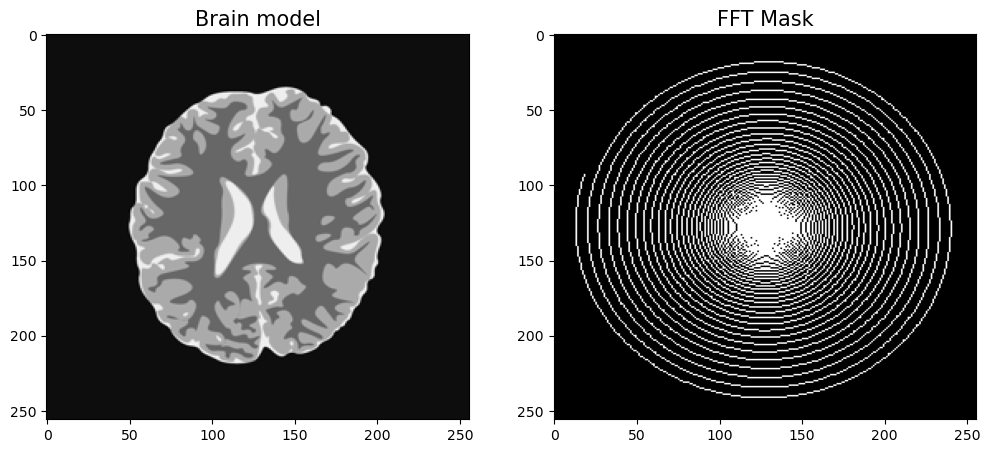

In [4]:
x = loadmat('../data/brainphantom.mat')
mask = loadmat('../data/spiralsampling.mat')

x = x['gt']
mask = mask['samp']
mask_fft = np.fft.ifftshift(mask)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(x, cmap='gray')
ax[0].axis('tight')
ax[0].set_title('Brain model', fontsize=15)
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('FFT Mask', fontsize=15)
ax[1].axis('tight');

In [5]:
# Reconstruction operator
Fop = FFT2D(dims=x.shape)
Rop = Restriction(x.size, np.where(mask_fft.ravel() == 1)[0], forceflat=True, dtype=np.complex128)
Op = Rop * Fop

# Data (optionally adding some noise)
sigman = 0.
x_fft = Fop * x.ravel()
x_fft = x_fft.reshape(x.shape)
y = Op * x.ravel()
y += np.random.normal(0, sigman, y.shape)

We create now our benchmark solution by simply zero-filling the empty values in the Fourier domain. This is a very poor approach that one could easily improve upon but provides an idea of the worst-case reconstruction.

In [6]:
# Zero-filling reconstruction
x_zero = mask_fft * x_fft
x_zero = Fop.H * x_zero.ravel()
x_zero = np.real(x_zero.reshape(x.shape))
snrzero = snr(x.ravel(), x_zero.ravel())

In [7]:
# Anisotropic TV reconstruction with ADMML2
sigma = .04
Gop = Gradient(dims=x.shape, edge=True, kind='forward', dtype=np.complex128)
l1 = pyproximal.L1(sigma=sigma)

# Solve
L = 8 # (Gop.H @ Gop).eigs(1)[0].real
tau = 1. / L

snraniso_hist = []
x_aniso = pyproximal.optimization.primal.ADMML2(l1, Op, y.ravel(), Gop, tau=tau,
                                                x0=np.zeros_like(x.ravel()),
                                                niter=100, show=True,
                                                callback=lambda xest: callback(xest, x.ravel(), snraniso_hist))[0]
x_aniso = x_aniso.reshape(x.shape).real
snraniso = snr(x.ravel(), x_aniso.ravel())

ADMM
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = 1.250000e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   4.01021e-02   9.389e+01   4.424e+01   1.381e+02
     2   4.61113e-02   6.318e+01   3.983e+01   1.030e+02
     3   4.93700e-02   4.485e+01   4.409e+01   8.893e+01
     4   5.13001e-02   3.643e+01   4.575e+01   8.218e+01
     5   5.22004e-02   3.141e+01   4.650e+01   7.792e+01
     6   5.24605e-02   2.799e+01   4.682e+01   7.481e+01
     7   5.27030e-02   2.547e+01   4.697e+01   7.244e+01
     8   5.29348e-02   2.355e+01   4.701e+01   7.056e+01
     9   5.29752e-02   2.202e+01   4.704e+01   6.906e+01
    10   5.30913e-02   2.078e+01   4.708e+01   6.786e+01
    11   5.32832e-02   1.975e+01   4.712e+01   6.686e+01
    21   5.42389e-02   1.443e+01   4.739e+01   6.182e+01
    31   5.41185e-02   1.232e+01   4.760e+01   5.992e+01
    41   5.41627e-02   1.120e+01   4.772e+01   5

In [8]:
# Isotropic TV reconstruction with ADMML2
sigma = .04
Gop = Gradient(dims=x.shape, edge=True, kind='forward', dtype=np.complex128)
l1 = pyproximal.proximal.L21(ndim=2, sigma=sigma)

# Solve
L = 8 # (Gop.H @ Gop).eigs(1)[0].real
tau = 1. / L

snriso_hist = []
x_iso = pyproximal.optimization.primal.ADMML2(l1, Op, y.ravel(), Gop, tau=tau,
                                              x0=np.zeros_like(x.ravel()),
                                              niter=100, show=True,
                                              callback=lambda xest: callback(xest, x.ravel(), snriso_hist))[0]
x_iso = x_iso.reshape(x.shape).real
snriso = snr(x.ravel(), x_iso.ravel())

ADMM
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
tau = 1.250000e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   4.01021e-02   9.389e+01   2.826e+01   1.221e+02
     2   4.70511e-02   6.120e+01   2.962e+01   9.083e+01
     3   5.16591e-02   4.364e+01   3.308e+01   7.672e+01
     4   5.41375e-02   3.496e+01   3.468e+01   6.964e+01
     5   5.44315e-02   2.954e+01   3.556e+01   6.510e+01
     6   5.46835e-02   2.581e+01   3.615e+01   6.196e+01
     7   5.47935e-02   2.307e+01   3.659e+01   5.966e+01
     8   5.53060e-02   2.107e+01   3.695e+01   5.802e+01
     9   5.46734e-02   1.953e+01   3.723e+01   5.676e+01
    10   5.50370e-02   1.826e+01   3.746e+01   5.572e+01
    11   5.48342e-02   1.722e+01   3.767e+01   5.489e+01
    21   5.42841e-02   1.197e+01   3.880e+01   5.078e+01
    31   5.42031e-02   9.959e+00   3.938e+01   4.934e+01
    41   5.39942e-02   8.911e+00   3.972e+01  

In [9]:
# Isotropic TV reconstruction with PD
sigma = 0.04
l1 = pyproximal.proximal.L21(ndim=2, sigma=sigma)
l2 = pyproximal.proximal.L2(Op=Op, b=y.ravel(), niter=50, warm=True)

# Solve
L = 8 # (Gop.H @ Gop).eigs(1)[0].real
tau = .99 / np.sqrt(L)
mu = .99 / np.sqrt(L)

snrisopd_hist = []
x_isopd = pyproximal.optimization.primaldual.PrimalDual(l2, l1, Gop, x0=np.zeros(x.size), 
                                                        tau=tau, mu=mu, theta=1., 
                                                        niter=100, show=False,
                                                        callback=lambda xest: callback(xest, x.ravel(), snrisopd_hist))
x_isopd = x_isopd.reshape(x.shape).real
snrisopd = snr(x.ravel(), x_isopd.ravel())

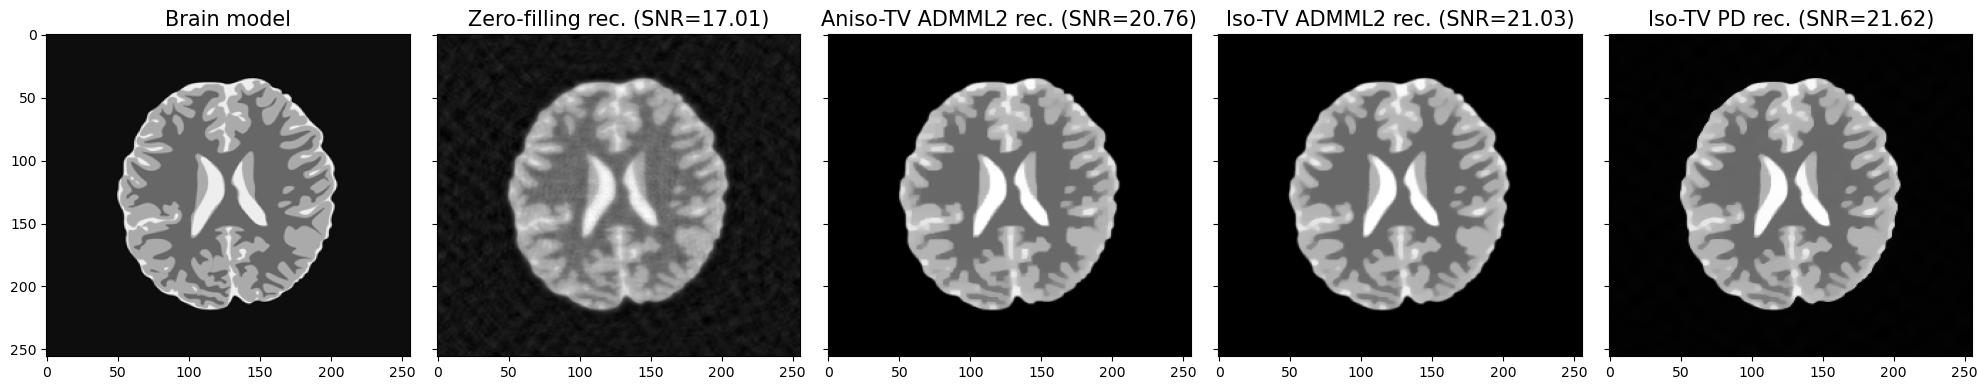

In [10]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(20, 4))
ax[0].imshow(x, cmap='gray')
ax[0].axis('tight')
ax[0].set_title('Brain model', fontsize=15)
ax[1].imshow(x_zero, cmap='gray')
ax[1].set_title('Zero-filling rec. (SNR=%.2f)' % snrzero, fontsize=15)
ax[1].axis('tight')
ax[2].imshow(x_aniso, cmap='gray')
ax[2].set_title('Aniso-TV ADMML2 rec. (SNR=%.2f)' % snraniso, fontsize=15)
ax[2].axis('tight')
ax[3].imshow(x_iso, cmap='gray')
ax[3].set_title('Iso-TV ADMML2 rec. (SNR=%.2f)' % snriso, fontsize=15)
ax[3].axis('tight')
ax[4].imshow(x_isopd, cmap='gray')
ax[4].set_title('Iso-TV PD rec. (SNR=%.2f)' % snrisopd, fontsize=15)
ax[4].axis('tight')
plt.tight_layout();

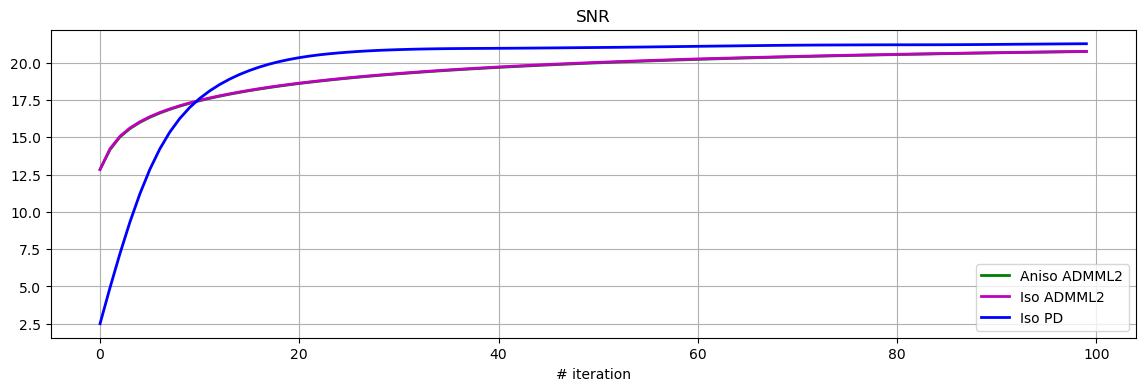

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(snraniso_hist, "g", lw=2, label="Aniso ADMML2")
ax.plot(snriso_hist, "m", lw=2, label="Iso ADMML2")
ax.plot(snrisopd_hist, "b", lw=2, label="Iso PD")
ax.set_title("SNR")
ax.set_xlabel('# iteration')
ax.grid()
ax.legend();

## Recap

In this tutorial we have learned to:

- How to set up an MRI reconstruction problem (remember, this is the multi-dimensional version of the problem presented in the ``FFTLinOp`` tutorial);
- How to include anisotropic and isotropic TV in different solvers.